In [7]:
import gzip
import numpy as np
import pandas as pd
from tqdm import tqdm

from multiprocessing import Pool
import multiprocessing as multi

Utils

In [8]:
# Create a pool of workers
num_cores = multi.cpu_count()
pool = Pool(processes=6)

In [9]:
def norm_compression_distance(args):
    """norm compression distance algorithm
    :param args: x1, training_set, k
    :return: predict class
    """

    x1, training_set, k = args
    Cx1 = len(gzip.compress(x1.encode()))
    distance_from_x1 = []

    for idx, training_tweet in enumerate(training_set):
        x2 = training_tweet[0]
        Cx2 = len(gzip.compress(x2.encode()))
        x1x2 = " ".join([x1, x2])
        Cx1x2 = len(gzip.compress(x1x2.encode()))

        ncd = (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)

        distance_from_x1.append((idx,ncd))
    
    distance_from_x1_df = pd.DataFrame(distance_from_x1, columns=['idx','ncd'])
    # print(distance_from_x1)
    sorted_idx = distance_from_x1_df.sort_values(by=['ncd'], ascending=True)['idx'].tolist()
    # print(sorted_idx[:k])
    top_k_class = training_set[sorted_idx[:k],1].tolist()
    predict_class = max(set(top_k_class), key=top_k_class.count)
    
    return predict_class


def find_k_grid(rng, label='label'):
    """Find k with grid search. 
    Can be used for a single scalar val of k by spec range(k,k+1)
    Utilizes multiprocessing.
    Requires training_set, test_set, test_set_sample to be defined.
    :param rng: range of k
    :param label: label name
    """
    grid = []
    for k in tqdm(rng):
        args = [(x1, training_set, k) for x1, _ in test_set]
        preds = pool.map(norm_compression_distance, args)

        # preds = np.array(preds)
        test_floor = test_set_sample.copy()
        test_floor['preds'] = preds
        test_floor['correct'] = test_floor[label] == test_floor['preds']
        accuracy = test_floor['correct'].sum() / len(test_floor)
        grid.append((k, accuracy))

    grid_df = pd.DataFrame(grid, columns=['k', 'accuracy'])
    grid_df.sort_values(by=['accuracy'], ascending=False)
    grid_df

    return grid_df

Params

In [10]:
sample_cnt = 100

# Twitter message classification

In [11]:
training_set_src = pd.read_csv(
    './data/Corona_NLP_train.csv',
    encoding='iso-8859-1'
)[['OriginalTweet', 'Sentiment']]
training_set_src.columns = ['tweet', 'label']
test_set_src = pd.read_csv(
    './data/Corona_NLP_test.csv',
    encoding='iso-8859-1'
)[['OriginalTweet', 'Sentiment']]
test_set_src.columns = ['tweet', 'label']

Check label distr

In [12]:
training_set_src['label'].value_counts(normalize=True)

label
Positive              0.277523
Negative              0.240955
Neutral               0.187404
Extremely Positive    0.160945
Extremely Negative    0.133173
Name: proportion, dtype: float64

In [13]:
test_set_src['label'].value_counts(normalize=True)

label
Negative              0.274092
Positive              0.249342
Neutral               0.162981
Extremely Positive    0.157715
Extremely Negative    0.155872
Name: proportion, dtype: float64

Form data sets

In [14]:
test_set_sample = test_set_src.sample(sample_cnt)
test_set = test_set_sample.to_numpy()
training_set = training_set_src.to_numpy()

In [15]:
# This grid search takes a long time to run
#
# corona_sentiment_grid = find_k_grid(range(1, 21))
# corona_sentiment_grid

In [16]:
# corona_sentiment_grid.plot(x='k', y='accuracy', kind='line', title='k vs accuracy')

Method yields low accuracy on the un-processed data set. We will choose k=7 for now and see how it performs also on the dataset with less labels.

In [17]:
# predict classes of tweets
k=7
args = [(x1, training_set, k) for x1, _ in test_set]
preds = pool.map(norm_compression_distance, args)

test_set_sample['preds'] = preds
test_set_sample['correct'] = test_set_sample['label'] == test_set_sample['preds']

ACC: 0.31


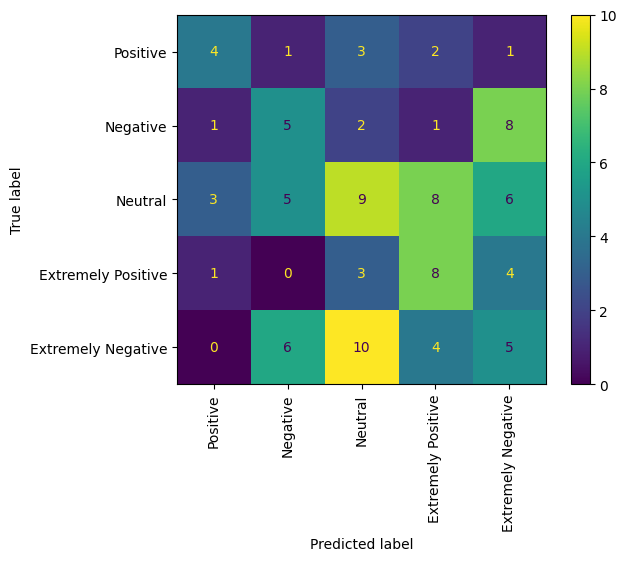

In [34]:
# calculate simple accuracy
acc = test_set_sample['correct'].sum() / len(test_set_sample)
print('ACC:', acc)

# use sklearn confusion matrix display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels = ['Positive', 'Negative', 'Neutral', 'Extremely Positive', 'Extremely Negative']
cm = confusion_matrix(test_set_sample['label'], test_set_sample['preds'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
_ = disp.plot(xticks_rotation=90)


This CM is a mess. Let's try classification with less labels

In [ ]:
#tbc

Try this method on a dataset from the paper
https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset

In [32]:
training_set_src = pd.read_csv(
    './data/AGNews_train.csv',
    encoding='iso-8859-1'
)
test_set_src = pd.read_csv(
    './data/AGNews_test.csv',
    encoding='iso-8859-1'
)
training_set_src.columns = ['label', 'title', 'description']
test_set_src.columns = ['label', 'title', 'description']

In [33]:
training_set_src['text'] = training_set_src['title'] + ' ' + training_set_src['description']
test_set_src['text'] = test_set_src['title'] + ' ' + test_set_src['description']

training_set = training_set_src[['text', 'label']].to_numpy()
test_set_sample = test_set_src.sample(sample_cnt)
test_set = test_set_sample[['text', 'label']].to_numpy()

In [39]:
agnews_grid = find_k_grid(range(5, 6), label='label')
agnews_grid

100%|██████████| 1/1 [09:14<00:00, 554.96s/it]


,k,accuracy
0,5,0.91
